# ***Sentiment Analysis***
Sentiment analysis is the process of detecting positive or negative sentiment in text. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers’ likes & dislikes. Since customers express their thoughts and feelings more openly than ever before, sentiment analysis is becoming an essential tool to monitor and understand that sentiment. Automatically analyzing customer feedback, such as opinions in survey responses and social media conversations, allows brands to learn what makes customers happy or frustrated. By virtue of knowing customer preference and feedback, companies are able to timely tailor products & services to meet their customers’ needs and expectations. For example, using sentiment analysis to automatically analyze 4,000+ reviews about your product could help you discover if customers are happy about your product acceptance and its value for money. 

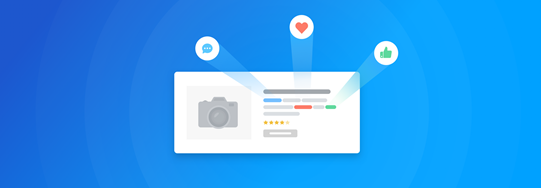

## ***Types of Sentiment Analysis***
Sentiment analysis models focus on polarity (positive, negative, neutral) but also on feelings and emotions (angry, happy, sad, etc.), urgency (urgent, not urgent) and even intentions (interested vs. not interested). Depending on how you want to interpret customer feedback and queries, you can define and tailor your categories to meet your sentiment analysis needs. Below is the overview of the most popular and frequently used types of sentiment analysis:

### **Fine-grained Sentiment Analysis**
When polarity precision is important to the business, Fine Grained Sentiment Analysis is preferred to include:

●	Very positive
●	Positive
●	Neutral
●	Negative
●	Very negative

This is usually referred to as fine-grained sentiment analysis, and could be used to interpret 5-star ratings in a review, for example:

●	Very Positive = 5 stars
●	Very Negative = 1 star

### **Emotion detection**
This type of sentiment analysis aims to detect emotions, like happiness, frustration, anger, sadness, and so on. Many emotion detection systems use lexicons (i.e. lists of words and the emotions they convey) or complex machine learning algorithms. One of the downsides of using lexicons is that people express emotions in different ways. Some words that typically express anger, like bad or kill (e.g. your product is so bad or your customer support is killing me) might also express happiness (e.g. this is bad ass or you are killing it).

### **Aspect-based Sentiment Analysis**
Usually, when analyzing sentiments of texts, let’s say product reviews, you’ll want to know which particular aspects or features people are mentioning in a positive, neutral, or negative way. That's where aspect-based sentiment analysis can help, for example in this text: "The battery life of this camera is too short", an aspect-based classifier would be able to determine that the sentence expresses a negative opinion about the feature battery life.

# ***Data Colection***
We have retrieved data of US 2020 election with hashtag of Donald Trump and Joe Biden from Kaggle (https://www.kaggle.com/manchunhui/us-election-2020-tweets). It contains almost 900000 tweets related to Donal Trump and 700000 tweets related to Joe Biden. Secondly to train our model we have retrieved labeled data with sentiments from Kaggle (https://www.kaggle.com/kazanova/sentiment140 ), It contains 1.6 million tweets annotated with sentiments.

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#! pip install pycld2

# ***Libraies Loaded***

In [ ]:
import numpy as np
import pandas as pd

#NLP Library
import spacy
import re

#Language Detect Library
import pycld2 as cld2

#Feature extraction, model selection and model training library
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#Libraries to check the model performance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Graphing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snb
from wordcloud import WordCloud, STOPWORDS

#Hypothesis Testing
import math
from scipy.stats import chi2_contingency, chisquare, chi2

# ***Data Preparation***
Data Cleansing and Data Transformation

In [ ]:
nlp = spacy.load("en_core_web_sm",disable=["tagger","parser","ner"])

# ***Clean Tweets Using Regex***
In it we removed some special characters and words that did not add any value in the sentiments of tweets but reduced processing time

In [ ]:
def clean_tweet_text_regex(tweet):
    tweet = tweet.lower() # to lower case
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet) # Remove @Mentions
    tweet = re.sub(r"#","", tweet) # remove # \ART[\s]+
    tweet = re.sub(r"\ART[\s]+","", tweet) # Remove RT in start
    tweet = re.sub(r"https?:\/\/\S+","", tweet) # Remove hyperlink
    tweet = re.sub("(.)\\1{2,}","\\1", tweet) # Remove more than one characters.
    tweet = re.sub(r"[^A-Za-z0-9\s]+", "",str(tweet)) #remove special characters "!"
    
    return tweet

# ***Clean Tweets Using Spacy***
We have used Spacy to remove stopwords and lemmatization. Since there are a very huge number of tweets in each dataset, we have created the nlp document in chunks and then split it into spans. Now we have used spans to remove the stopwords and replace the lemma word

In [ ]:
def clean_tweet_spacy_core(doc):
    tokens= []

    for token in doc:
        if token.is_stop:
            continue
        if token.text != token.lemma_:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text)
      
    
    tweet=" ".join(tokens)
    return tweet

In [ ]:
def doc_to_spans(list_of_texts, join_string=' ||| '):
    all_docs = nlp(' ||| '.join(list_of_texts))
    split_inds = [i for i, token in enumerate(all_docs) if token.text == '|||'] + [len(all_docs)]
    new_docs = [all_docs[(i + 1 if i > 0 else i):j] for i, j in zip([0] + split_inds[:-1], split_inds)]
    all_docs = None
    return new_docs 

def get_complete_spans(data,colname):
    splitted_frames = np.array_split(data, 500)
    docs=[]
    i = 1
    for frame in splitted_frames:
        docs.append(doc_to_spans(frame[colname]))
    return docs

In [ ]:
def clean_tweet_spacy(data, colname):
    docs = get_complete_spans(data, colname)
    
    print("Tweets cleaning started")
    tweets = []
    
    for doces in docs:
        for doc in doces:
            tweets.append(clean_tweet_spacy_core(doc))

    print("Tweets cleanned")
    return tweets

# ***Detecting Language***
Now we have used https://pypi.org/project/pycld2/ library to detect the languages of tweets. We have only used English tweets in this project to analyze the sentiments.

In [ ]:
def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return "not found"

In [ ]:
labeled_data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")

In [ ]:
labeled_data.head()

In [ ]:
labeled_data.columns = ["label", "time", "date", "query", "username", "text"]

In [ ]:
labeled_data.head()

In [ ]:
def check_col_null_values(data):
    col_null_values = pd.DataFrame(columns=["column","nullvalues"])
    null_values = []

    for col in data.columns:
        sum = data[col].isnull().sum()
        print(f"{col}: null percent: {sum/data.shape[0]*100} null values: {sum}/{data.shape[0]} value count: {data.shape[0] - sum}/{data.shape[0]}")
        null_values.append(sum)
    
    col_null_values["column"] = data.columns
    col_null_values["nullvalues"] = null_values

    return col_null_values

In [ ]:
check_col_null_values(labeled_data)

In [ ]:
labeled_data["text"] = labeled_data["text"].apply(clean_tweet_text_regex)

In [ ]:
train_langs = labeled_data["text"].apply(detect_lang)

In [ ]:
train_langs.value_counts()

In [ ]:
labeled_data["Lang"] = train_langs

In [ ]:
eng_train_data = labeled_data[labeled_data["Lang"] == "ENGLISH"]

In [ ]:
len(eng_train_data)

In [ ]:
eng_train_data["text"] = clean_tweet_spacy(eng_train_data,"text")

In [ ]:
if np.sum(labeled_data["text"].isnull()) > 0:
    labeled_data = labeled_data.dropna(subset=['text'])

In [ ]:
trump_tweets = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv", engine="python")
trump_tweets.head()

In [ ]:
trump_tweets.columns

In [ ]:
columns = ["tweet", "created_at", 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code']

trump_tweets = trump_tweets[columns]

trump_tweets.head()

In [ ]:
col_null_values = check_col_null_values(trump_tweets)

In [ ]:
plt.figure(figsize=(24,6))

snb.barplot(x=col_null_values["column"], y=col_null_values["nullvalues"])

plt.title("Null Values in Donald Trump Dataset")

In [ ]:
trump_tweets.dtypes

In [ ]:
def clean_data_frame(dataframe):
    dataframe['likes'] = pd.to_numeric(dataframe['likes'], errors="coerce")
    dataframe['user_followers_count'] = pd.to_numeric(dataframe['user_followers_count'], errors="coerce")
    dataframe["likes"].fillna(dataframe["likes"].mean(), inplace=True)
    dataframe["retweet_count"].fillna(dataframe["retweet_count"].mean(), inplace=True)
    #dataframe["user_followers_count"].fillna(dataframe["user_followers_count"].mean(), inplace=True) ??
    dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors="coerce") 
    dataframe["created_at"] = dataframe["created_at"].dt.strftime('%m-%d')

In [ ]:
clean_data_frame(trump_tweets)

In [ ]:
np.sum(trump_tweets["tweet"].isnull())

In [ ]:
trump_tweets = trump_tweets.dropna(subset=['tweet'])

In [ ]:
check_col_null_values(trump_tweets)

In [ ]:
trump_tweets["tweet"] = trump_tweets["tweet"].apply(clean_tweet_text_regex)

In [ ]:
trump_langs = trump_tweets["tweet"].apply(detect_lang)

In [ ]:
trump_langs.unique()

In [ ]:
trump_tweets["Lang"] = trump_langs

In [ ]:
eng_tweet_trump = trump_tweets[trump_tweets["Lang"] == "ENGLISH"]

In [ ]:
eng_tweet_trump["tweet"] = clean_tweet_spacy(eng_tweet_trump, "tweet")

In [ ]:
joebiden_tweets = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv", engine="python")
joebiden_tweets.head()

In [ ]:
joebiden_tweets = joebiden_tweets[columns]

In [ ]:
joe_col_null_values = check_col_null_values(joebiden_tweets)

In [ ]:
plt.figure(figsize=(24,6))

snb.barplot(x=joe_col_null_values["column"], y=joe_col_null_values["nullvalues"])
plt.title("Null Values in Joe Biden Dataset")

In [ ]:
joebiden_tweets.dtypes

In [ ]:
clean_data_frame(joebiden_tweets)

In [ ]:
np.sum(joebiden_tweets["tweet"].isnull())

In [ ]:
joebiden_tweets = joebiden_tweets.dropna(subset=['tweet'])

In [ ]:
joebiden_tweets["tweet"] = joebiden_tweets["tweet"].apply(clean_tweet_text_regex)

In [ ]:
joe_langs = joebiden_tweets["tweet"].apply(detect_lang)

In [ ]:
joe_langs.unique()

In [ ]:
joe_langs.value_counts()

In [ ]:
joebiden_tweets["Lang"] = joe_langs

In [ ]:
eng_joebiden_tweets = joebiden_tweets[joebiden_tweets["Lang"] == "ENGLISH"]

In [ ]:
eng_joebiden_tweets["tweet"] = clean_tweet_spacy(eng_joebiden_tweets, "tweet")

# ***Exploratory Data Analysis***


# ***Analyzed Top 10 Languages in All Datasets***
We have only used English tweets in this project to analyze the sentiments.

In [ ]:
trian_languages = labeled_data["Lang"].value_counts()

trian_languages

In [ ]:
trump_langs_value_count = trump_langs.value_counts()

trump_langs_value_count

In [ ]:
jeo_lang_count = joe_langs.value_counts()

jeo_lang_count

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 8))

#plt.figure(figsize=(16,6))
fig.tight_layout(pad=3.0)
plt.setp(axes, xlabel="Languages", ylabel="Count")
axes[0].set_title("Train Data Top Ten Languages Count")
axes[1].set_title("Trump Data Top Ten Languages Count")
axes[2].set_title("Joe Biden Data Top Ten Languages Count")
snb.barplot(x=trian_languages.index[:10], y=trian_languages.values[:10], ax=axes[0])

snb.barplot(x=trump_langs_value_count.index[:10], y=trump_langs_value_count.values[:10], ax=axes[1])

snb.barplot(x=jeo_lang_count.index[:10], y=jeo_lang_count.values[:10], ax=axes[2])

# ***Analyzed Tweets, Likes and Retweets Count w.r.t. Date.***
First we have analyzed the count of tweets and likes for both the participants w.r.t. Date and according to graph Joe Biden Graph is increasing by time.

Now we have analyzed the count of retweets for both the participants w.r.t. Date and according to the graph Donald Trump retweets count is increasing by time.

In [ ]:
trump_tweets_by_date = trump_tweets.groupby("created_at")

trump_tweets_count_by_date = trump_tweets_by_date.count()

trump_tweets_by_date_sum = trump_tweets_by_date.sum(numeric_only=True)

In [ ]:
joe_tweets_by_date = joebiden_tweets.groupby("created_at")

joe_tweets_count_by_date = joe_tweets_by_date.count()

joe_tweets_by_date_sum = joe_tweets_by_date.sum(numeric_only=True)

In [ ]:
tweet_df = pd.DataFrame(columns=["Date", "Trump Tweets Count", "Joe Biden Tweet Count"])
tweet_df["Date"] = trump_tweets_count_by_date.index
tweet_df["Trump Tweets Count"] = list(trump_tweets_count_by_date.tweet)
tweet_df["Joe Biden Tweet Count"] = list(joe_tweets_count_by_date.tweet)

tweet_df.set_index("Date", inplace=True)


In [ ]:
plt.figure(figsize=(16,6))

snb.lineplot(data=tweet_df)
plt.title("Tweets count w.r.t. Date")
plt.ylabel("Tweet Counts")

In [ ]:
likes_df = pd.DataFrame(columns=["Date", "Trump Likes", "Joe Biden Likes"])
likes_df["Date"] = trump_tweets_count_by_date.index
likes_df["Trump Likes"] = list(trump_tweets_by_date_sum.likes)
likes_df["Joe Biden Likes"] = list(joe_tweets_by_date_sum.likes)

likes_df.set_index("Date", inplace=True)

In [ ]:
plt.figure(figsize=(16,6))

snb.lineplot(data=likes_df)

plt.title("Likes count w.r.t. Date")
plt.ylabel("Likes Counts")

In [ ]:
retweet_count_df = pd.DataFrame(columns=["Date", "Trump Retweet Count", "Joe Biden Retweet Count"])
retweet_count_df["Date"] = trump_tweets_count_by_date.index
retweet_count_df["Trump Retweet Count"] = list(trump_tweets_by_date_sum.retweet_count)
retweet_count_df["Joe Biden Retweet Count"] = list(joe_tweets_by_date_sum.retweet_count)

retweet_count_df.set_index("Date", inplace=True)

In [ ]:
plt.figure(figsize=(16,6))

snb.lineplot(data=retweet_count_df)

plt.title("Retweets count w.r.t. Date")
plt.ylabel("Retweets Counts")

# ***Word Cloud Of Donald Trump and Joe Biden Tweets***

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in eng_tweet_trump['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Trump Tweets Word Cloud")


In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in eng_tweet_trump['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Joe Biden Tweets Word Cloud")

# ***Building a Model***
First of all we have extracted features from tweets using HashVectorizer and then we have splitted our training data in 80-20 ratio. We have tried different algorithms but due huge dataset including huge number of features and rows, very limited number of algorithms worked quickly. In Others like Random Forest, SVM we waited for a very long time it did not completed training. Only Naive Bayessian (GaussianNB) and LogisticRegression worked Quickly. Among these two LogisticRegression had given us 77% of accuracy and Naive Bayessian gave 50% of accuracy. So we have selected LogisticRegression. Once our model is trainned we used this model to find the sentiments of the tweets of both the participants.

In [ ]:
def train_model(train_data, targets):
    X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.2)

    model = Pipeline([('vect', HashingVectorizer()),
                      ('logreg', LogisticRegression(max_iter=1000, solver="saga")),
              ])
    model.fit(X_train, Y_train)

    return model, X_test, Y_test

In [ ]:
def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

In [ ]:
train_data = eng_train_data['text']

In [ ]:
targets = eng_train_data["label"]

In [ ]:
model, x_test, y_test = train_model(train_data, targets)

In [ ]:
check_model_metrics(model, x_test, y_test)

In [ ]:
def get_sentiments(model, data, level_of_signifence):
    sentiments=[]
    polarity = []
    prediction_prob = model.predict_proba(data)

    for prob in prediction_prob:
        dif = prob[1] - prob[0]
        polarity.append(prob[1])
        if dif >= -level_of_signifence and dif <= level_of_signifence:
            sentiments.append("Neutral")
        elif dif > level_of_signifence:
            sentiments.append("Positive")
        else:
            sentiments.append("Negative")
            
    return sentiments, polarity

In [ ]:
trump_tweets_data = eng_tweet_trump["tweet"]

In [ ]:
trump_sentiments, tump_polarity = get_sentiments(model, trump_tweets_data, 0.1)

In [ ]:
joe_tweets_data = eng_joebiden_tweets["tweet"]

In [ ]:
joe_sentiments, joe_polarity = get_sentiments(model, joe_tweets_data, 0.1)

# ***Presentation Of Final Results***
After sentiments of Donald Trump and Joe Biden Tweets are determined, we have shown that Joe Biden had won the elections 2020 according to the sentiments in tweets also. First we have analyzed sentiments counts w.r.t. Country and states of both the participants. Then we have analyzed Average polarity w.r.t. Date of both the participants. Then we have analyzed Sentiment count w.r.t. Date of both the participants. Then we have analyzed likes of the sentiments w.r.t. Date of both the participants. Then we have analyzed Sentiment retweets w.r.t. Date of both the participants. Lastly we have shown the pie chart of the percentage of positive, neutral and negative tweets of both the participants.

In [ ]:
pd.Series(trump_sentiments).value_counts(normalize=True)

In [ ]:
pd.Series(joe_sentiments).value_counts(normalize=True)

In [ ]:
eng_tweet_trump["sentiments"] = trump_sentiments
eng_tweet_trump["polarity"] = tump_polarity

In [ ]:
eng_joebiden_tweets["sentiments"] = joe_sentiments
eng_joebiden_tweets["polarity"] = joe_polarity

In [ ]:
frame = (eng_tweet_trump["country"].value_counts(normalize=True)*100).to_frame()

In [ ]:
trump_contries = frame[frame["country"] >= 1].index

In [ ]:
trump_countrywise_tweets = eng_tweet_trump[eng_tweet_trump["country"].isin(trump_contries)][["country","sentiments","tweet"]]


In [ ]:
trump_countrywise_tweets_count = trump_countrywise_tweets.groupby(["country", "sentiments"]).count()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_trump_countrywise_sentiments= pd.DataFrame(columns=["country", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_countrywise_sentiments["country"] = trump_contries
df_trump_countrywise_sentiments["Positive Tweets Count"] = [0]*len(trump_contries)
df_trump_countrywise_sentiments["Neutral Tweets Count"] = [0]*len(trump_contries)
df_trump_countrywise_sentiments["Negative Tweets Count"] = [0]*len(trump_contries)

for item in trump_countrywise_tweets_count.index:
  country = item[0]
  if item[1] == "Positive":
    
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Positive Tweets Count'] = trump_countrywise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Negative Tweets Count']= trump_countrywise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Neutral Tweets Count']= trump_countrywise_tweets_count.tweet[i]
  i+=1



df_trump_countrywise_sentiments.set_index("country", inplace=True)

In [ ]:
pp = (df_trump_countrywise_sentiments["Positive Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

nup = (df_trump_countrywise_sentiments["Neutral Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

np = (df_trump_countrywise_sentiments["Negative Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

df_trump_countrywise_sentiments["Positive Tweets Count"] = pp

df_trump_countrywise_sentiments["Neutral Tweets Count"] = nup

df_trump_countrywise_sentiments["Negative Tweets Count"] = np


In [ ]:
frame = (eng_joebiden_tweets["country"].value_counts(normalize=True)*100).to_frame()

In [ ]:
joe_contries = frame[frame["country"] >= 1].index

In [ ]:
joe_countrywise_tweets = eng_joebiden_tweets[eng_joebiden_tweets["country"].isin(joe_contries)][["country","sentiments","tweet"]]


In [ ]:
joe_countrywise_tweets_count = joe_countrywise_tweets.groupby(["country", "sentiments"]).count()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_joe_countrywise_sentiments= pd.DataFrame(columns=["country", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_countrywise_sentiments["country"] = joe_contries
df_joe_countrywise_sentiments["Positive Tweets Count"] = [0]*len(joe_contries)
df_joe_countrywise_sentiments["Neutral Tweets Count"] = [0]*len(joe_contries)
df_joe_countrywise_sentiments["Negative Tweets Count"] = [0]*len(joe_contries)

for item in joe_countrywise_tweets_count.index:
  country = item[0]
  if item[1] == "Positive":
    
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Positive Tweets Count'] = joe_countrywise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Negative Tweets Count']= joe_countrywise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Neutral Tweets Count']= joe_countrywise_tweets_count.tweet[i]
  i+=1



df_joe_countrywise_sentiments.set_index("country", inplace=True)

In [ ]:
pp = (df_joe_countrywise_sentiments["Positive Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

nup = (df_joe_countrywise_sentiments["Neutral Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

np = (df_joe_countrywise_sentiments["Negative Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

df_joe_countrywise_sentiments["Positive Tweets Count"] = pp

df_joe_countrywise_sentiments["Neutral Tweets Count"] = nup

df_joe_countrywise_sentiments["Negative Tweets Count"] = np


In [ ]:
plot = df_trump_countrywise_sentiments.plot(kind="bar",figsize=(16,6),color=["blue","Green","red"])

plt.title("Donald Trump Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")
for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

In [ ]:
plot = df_joe_countrywise_sentiments.plot(kind="bar",figsize=(16,6),color=["blue","Green","red"])
plt.title("Joe Biden Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

In [ ]:
trump_US_tweets = pd.concat([eng_tweet_trump[eng_tweet_trump["country"] == "United States of America"], eng_tweet_trump[eng_tweet_trump["country"] == "United States"]])

joe_US_tweets = pd.concat([eng_joebiden_tweets[eng_joebiden_tweets["country"] == "United States of America"], eng_joebiden_tweets[eng_joebiden_tweets["country"] == "United States"]])

In [ ]:
frame = (trump_US_tweets["state"].value_counts(normalize=True)*100).to_frame()
trump_states = frame[frame["state"] >= 1].index

trump_US_tweets = trump_US_tweets[trump_US_tweets["state"].isin(trump_states)]

In [ ]:
frame = (joe_US_tweets["state"].value_counts(normalize=True)*100).to_frame()
joe_states = frame[frame["state"] >= 1].index

joe_US_tweets = joe_US_tweets[joe_US_tweets["state"].isin(joe_states)]

In [ ]:
trump_US_tweets_groupby_state_sent = trump_US_tweets.groupby(["state", "sentiments"])

joe_US_tweets_groupby_state_sent = joe_US_tweets.groupby(["state", "sentiments"])

In [ ]:
trump_US_tweets_groupby_state_sent_count = trump_US_tweets_groupby_state_sent.count()

joe_US_tweets_groupby_state_sent_count = joe_US_tweets_groupby_state_sent.count()

In [ ]:
us_trump_states = trump_US_tweets_groupby_state_sent_count.index.to_frame()["state"].unique()

us_joe_states = joe_US_tweets_groupby_state_sent_count.index.to_frame()["state"].unique()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_trump_statewise_sentiments= pd.DataFrame(columns=["State", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_statewise_sentiments["State"] = us_trump_states
df_trump_statewise_sentiments["Positive Tweets Count"] = [0]*len(us_trump_states)
df_trump_statewise_sentiments["Neutral Tweets Count"] = [0]*len(us_trump_states)
df_trump_statewise_sentiments["Negative Tweets Count"] = [0]*len(us_trump_states)

for item in trump_US_tweets_groupby_state_sent_count.index:
  state = item[0]
  if item[1] == "Positive":
    
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Positive Tweets Count'] = trump_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Negative":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Negative Tweets Count']= trump_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Neutral":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Neutral Tweets Count']= trump_US_tweets_groupby_state_sent_count.tweet[i]
  i+=1


pp = (df_trump_statewise_sentiments["Positive Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

nup = (df_trump_statewise_sentiments["Neutral Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

np = (df_trump_statewise_sentiments["Negative Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

df_trump_statewise_sentiments["Positive Tweets Count"] = pp

df_trump_statewise_sentiments["Neutral Tweets Count"] = nup

df_trump_statewise_sentiments["Negative Tweets Count"] = np


df_trump_statewise_sentiments.set_index("State", inplace=True)

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_joe_statewise_sentiments= pd.DataFrame(columns=["State", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_statewise_sentiments["State"] = us_joe_states
df_joe_statewise_sentiments["Positive Tweets Count"] = [0]*len(us_joe_states)
df_joe_statewise_sentiments["Neutral Tweets Count"] = [0]*len(us_joe_states)
df_joe_statewise_sentiments["Negative Tweets Count"] = [0]*len(us_joe_states)

for item in joe_US_tweets_groupby_state_sent_count.index:
  state = item[0]
  if item[1] == "Positive":
    
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Positive Tweets Count'] = joe_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Negative":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Negative Tweets Count']= joe_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Neutral":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Neutral Tweets Count']= joe_US_tweets_groupby_state_sent_count.tweet[i]
  i+=1


pp = (df_joe_statewise_sentiments["Positive Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

nup = (df_joe_statewise_sentiments["Neutral Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

np = (df_joe_statewise_sentiments["Negative Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

df_joe_statewise_sentiments["Positive Tweets Count"] = pp

df_joe_statewise_sentiments["Neutral Tweets Count"] = nup

df_joe_statewise_sentiments["Negative Tweets Count"] = np

df_joe_statewise_sentiments.set_index("State", inplace=True)

In [ ]:
plot = df_trump_statewise_sentiments.plot(kind="bar",figsize=(16,10),color=["blue","Green","red"])

plt.title("Donald Trump Sentiment Percent w.r.t. States")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

In [ ]:
plot = df_joe_statewise_sentiments.plot(kind="bar",figsize=(16,10),color=["blue","Green","red"])

plt.title("Joe Biden Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

In [ ]:
trump_US_tweets_groupby_date = trump_US_tweets.groupby("created_at")

joe_US_tweets_groupby_date = joe_US_tweets.groupby("created_at")

In [ ]:
trump_groupby_date_mean = trump_US_tweets_groupby_date.mean()

joe_groupby_date_mean = joe_US_tweets_groupby_date.mean()

In [ ]:
datewise_polarity = pd.DataFrame(columns=["Date", "Trump Polarity", "Joe Polarity"])
dates = trump_groupby_date_mean.index
datewise_polarity["Date"] = dates
datewise_polarity["Trump Polarity"] = list(trump_groupby_date_mean.polarity)
datewise_polarity["Joe Polarity"] =list(joe_groupby_date_mean.polarity)

datewise_polarity.set_index("Date", inplace=True)

In [ ]:
plt.figure(figsize=(16,6))

plt.title("Average Polarity w.r.t. Date")
plt.ylabel("Average Polarity")

snb.lineplot(data=datewise_polarity)

In [ ]:
trump_US_tweets_gp_date_sent = trump_US_tweets.groupby(["created_at","sentiments"])
joe_US_tweets_gp_date_sent = joe_US_tweets.groupby(["created_at","sentiments"])

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0
trump_US_tweets_gp_date_sent_count = trump_US_tweets_gp_date_sent.count()

for item in trump_US_tweets_gp_date_sent_count.index:
  if item[1] == "Positive":
    positive_tweets.append(trump_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Negative":
    negative_tweets.append(trump_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Neutral":
    neutral_tweets.append(trump_US_tweets_gp_date_sent_count.tweet[i])
  i+=1

df_trump_datewise_sentiments = pd.DataFrame(columns=["Date", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_datewise_sentiments["Date"] = dates
df_trump_datewise_sentiments["Positive Tweets Count"] = positive_tweets
df_trump_datewise_sentiments["Neutral Tweets Count"] = neutral_tweets
df_trump_datewise_sentiments["Negative Tweets Count"] = negative_tweets

df_trump_datewise_sentiments.set_index("Date", inplace=True)

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0
joe_US_tweets_gp_date_sent_count = joe_US_tweets_gp_date_sent.count()

for item in joe_US_tweets_gp_date_sent_count.index:
  if item[1] == "Positive":
    positive_tweets.append(joe_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Negative":
    negative_tweets.append(joe_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Neutral":
    neutral_tweets.append(joe_US_tweets_gp_date_sent_count.tweet[i])
  i+=1

df_joe_datewise_sentiments = pd.DataFrame(columns=["Date", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_datewise_sentiments["Date"] = dates
df_joe_datewise_sentiments["Positive Tweets Count"] = positive_tweets
df_joe_datewise_sentiments["Neutral Tweets Count"] = neutral_tweets
df_joe_datewise_sentiments["Negative Tweets Count"] = negative_tweets

df_joe_datewise_sentiments.set_index("Date", inplace=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments")
axes[1].set_title("Joe Biden Datewise Sentiments")

snb.lineplot(data=df_trump_datewise_sentiments,ax=axes[0], palette=["blue","orange", "red"])
snb.lineplot(data=df_joe_datewise_sentiments,ax=axes[1], palette=["blue","orange", "red"])

In [ ]:
positive_likes = []
neutral_likes = []
negative_likes = []
i = 0
trump_US_tweets_gp_date_sent_sum = trump_US_tweets_gp_date_sent.sum()

for item in trump_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_likes.append(trump_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Negative":
    negative_likes.append(trump_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Neutral":
    neutral_likes.append(trump_US_tweets_gp_date_sent_sum.likes[i])
  i+=1

df_trump_datewise_sentiments_likes = pd.DataFrame(columns=["Date", "Positive Tweets Like", "Neutral Tweets Like", "Negative Tweets Like"])

df_trump_datewise_sentiments_likes["Date"] = dates
df_trump_datewise_sentiments_likes["Positive Tweets Like"] = positive_likes
df_trump_datewise_sentiments_likes["Neutral Tweets Like"] = neutral_likes
df_trump_datewise_sentiments_likes["Negative Tweets Like"] = negative_likes

df_trump_datewise_sentiments_likes.set_index("Date", inplace=True)

In [ ]:
positive_likes = []
neutral_likes = []
negative_likes = []
i = 0
joe_US_tweets_gp_date_sent_sum = joe_US_tweets_gp_date_sent.sum()

for item in joe_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_likes.append(joe_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Negative":
    negative_likes.append(joe_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Neutral":
    neutral_likes.append(joe_US_tweets_gp_date_sent_sum.likes[i])
  i+=1

df_joe_datewise_sentiments_likes = pd.DataFrame(columns=["Date", "Positive Tweets Like", "Neutral Tweets Like", "Negative Tweets Like"])

df_joe_datewise_sentiments_likes["Date"] = dates
df_joe_datewise_sentiments_likes["Positive Tweets Like"] = positive_likes
df_joe_datewise_sentiments_likes["Neutral Tweets Like"] = neutral_likes
df_joe_datewise_sentiments_likes["Negative Tweets Like"] = negative_likes

df_joe_datewise_sentiments_likes.set_index("Date", inplace=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments Likes")
axes[1].set_title("Joe Biden Datewise Sentiments Likes")

snb.lineplot(data=df_trump_datewise_sentiments_likes,ax=axes[0], palette=["blue","orange", "red"])
snb.lineplot(data=df_joe_datewise_sentiments_likes,ax=axes[1], palette=["blue","orange", "red"])

In [ ]:
positive_retweets = []
neutral_retweets = []
negative_retweets = []
i = 0
trump_US_tweets_gp_date_sent_sum = trump_US_tweets_gp_date_sent.sum()

for item in trump_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_retweets.append(trump_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Negative":
    negative_retweets.append(trump_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Neutral":
    neutral_retweets.append(trump_US_tweets_gp_date_sent_sum.retweet_count[i])
  i+=1

df_trump_datewise_sentiments_retweets = pd.DataFrame(columns=["Date", "Positive Tweets Retweets", "Neutral Tweets Retweets", "Negative Tweets Retweets"])

df_trump_datewise_sentiments_retweets["Date"] = dates
df_trump_datewise_sentiments_retweets["Positive Tweets Retweets"] = positive_retweets
df_trump_datewise_sentiments_retweets["Neutral Tweets Retweets"] = neutral_retweets
df_trump_datewise_sentiments_retweets["Negative Tweets Retweets"] = negative_retweets

df_trump_datewise_sentiments_retweets.set_index("Date", inplace=True)

In [ ]:
positive_retweet = []
neutral_retweet = []
negative_retweet = []
i = 0
joe_US_tweets_gp_date_sent_sum = joe_US_tweets_gp_date_sent.sum()

for item in joe_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_retweet.append(joe_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Negative":
    negative_retweet.append(joe_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Neutral":
    neutral_retweet.append(joe_US_tweets_gp_date_sent_sum.retweet_count[i])
  i+=1

df_joe_datewise_sentiments_retweets = pd.DataFrame(columns=["Date", "Positive Tweets Retweets", "Neutral Tweets Retweets", "Negative Tweets Retweets"])

df_joe_datewise_sentiments_retweets["Date"] = dates
df_joe_datewise_sentiments_retweets["Positive Tweets Retweets"] = positive_retweet
df_joe_datewise_sentiments_retweets["Neutral Tweets Retweets"] = neutral_retweet
df_joe_datewise_sentiments_retweets["Negative Tweets Retweets"] = negative_retweet

df_joe_datewise_sentiments_retweets.set_index("Date", inplace=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments Retweets")
axes[1].set_title("Joe Biden Datewise Sentiments Retweets")

snb.lineplot(data=df_trump_datewise_sentiments_retweets,ax=axes[0], palette=["blue","orange", "red"])
snb.lineplot(data=df_joe_datewise_sentiments_retweets,ax=axes[1], palette=["blue","orange", "red"])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Sentiments Ratio")
axes[1].set_title("Joe Biden Sentiments Ratio")

trump_sentiments_values = eng_tweet_trump["sentiments"].value_counts()
joe_sentiments_values = eng_joebiden_tweets["sentiments"].value_counts()

axes[0].pie(x=trump_sentiments_values.values, autopct="%.1f%%", explode=[0.05,0, 0], colors=["green","orange","gray"],labels=trump_sentiments_values.index, pctdistance=0.5)
axes[1].pie(x=joe_sentiments_values.values, autopct="%.1f%%", explode=[0.05,0, 0], colors=["green","orange","gray"],labels=joe_sentiments_values.index, pctdistance=0.5)


# ***Hypothesis Testing***

# ***First Hypothesis***
H0 = Average polarity of Joe Biden is greater than overall average polarity.

Ha = Average polarity of Joe Biden is lesser than overall average polarity.

In [ ]:
 all_polarity = pd.concat([eng_tweet_trump["polarity"], eng_joebiden_tweets["polarity"]])

In [ ]:
sample = eng_joebiden_tweets["polarity"].sample(n=50)

In [ ]:
x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

In [ ]:
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)



---


Alpha = 0.05
Z_tabular = 1.65

As,

***Z_calc < Z_tabular***

So H0 is accepted and Average polarity of Joe Biden is greater than overall average polarity.

---



# ***Second Hypothesis***
Ho = Sentiments of Joe Biden is dependent or related to states

Ha = Sentiments of Joe Biden is Independent or not related to states

In [ ]:
chiObservedData = pd.crosstab(joe_US_tweets["sentiments"], joe_US_tweets["state"])

In [ ]:
chiObservedData

In [ ]:
stat, p, ddof, expected = chi2_contingency(chiObservedData)

In [ ]:
stat, p, ddof, expected

In [ ]:
chi_value, p_value = chisquare(chiObservedData, expected)

In [ ]:
chi_value, p_value

In [ ]:
print("Chi-Square Calculated Value:",  chi_value.sum())

In [ ]:
alpha = 0.05
prob = 1 - alpha
critical_value = chi2.ppf(prob, ddof)
print("Critcal Value: ", critical_value)

In [ ]:
p<alpha



---


Since

***chi-square-value > critical_value***

and also

***p < alpha***

So H0 is rejected and Sentiments of Joe Biden is Independent or not related to states

---




# ***Third Hypothesis***
H0 = Average polarity among high profile users of Joe Biden is greater than overall average polarity among high profile users.

Ha = Average polarity among high profile users of Joe Biden is lesser than overall average polarity among high profile users.

In [ ]:
joe_high_profile_user_tweets = joe_US_tweets[joe_US_tweets["user_followers_count"] > 100000]

In [ ]:
print("No. of high profile users in US tweeted for Joe Biden: ", len(joe_high_profile_user_tweets["user_id"].unique()))

In [ ]:
trump_high_profile_user_tweets = trump_US_tweets[trump_US_tweets["user_followers_count"] > 100000]

In [ ]:
print("No. of high profile users in US tweeted for Donald Trump: ", len(trump_high_profile_user_tweets["user_id"].unique()))

In [ ]:
all_polarity_high_profile_users = pd.concat([trump_high_profile_user_tweets["polarity"], joe_high_profile_user_tweets["polarity"]])

In [ ]:
sample_joe_high_profile_users = joe_high_profile_user_tweets["polarity"].sample(n=50)

In [ ]:
x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

In [ ]:
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)



---


Alpha = 0.05
Z_tabular = 1.65

As,

***Z_calc < Z_tabular***

So H0 is accepted and Average polarity among high profile users of Joe Biden is greater than overall average polarity among high profile users.

---
